# Predicting Reviews Sentiment with Naive Bayes and Other Text Classifiers:

*Classification is the process of identifying the category of a new, unseen observation based of a training set of data, which has categories that are known.*

**In our case, our reviews are the observations and the positive/negative sentiment are the categories. This is a binary classification problem -- we're trying to predict if a review is either positive or negative.**

** Importing the basic libraries**

In [21]:
import math
import random
from collections import defaultdict
from pprint import pprint

# Prevent future/deprecation warnings from showing in output
import warnings
warnings.filterwarnings(action='ignore')

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Set global styles for plots
sns.set_style(style='white')
sns.set_context(context='notebook', font_scale=1.3, rc={'figure.figsize': (16,9)})

#### Loading the Dataset:

In [22]:
df = pd.read_csv('NB_Data.csv')
df.head()

,sentiment,review
0,P,The Samsung Galaxy s9 is arguably the most bea...
1,P,"great phone smart features easy to use ,, , p..."
2,P,I really liked the phone. It has good camera w...
3,P,First of all the camera quality does not disap...
4,P,"As a flagship phone goes, everything is pretty..."


*Now that we have the dataset in a dataframe, We removed the reviews for which the sentiments can not be identified, so we can focus on only classifying positive or negative:*

In [23]:
df = df[df['sentiment'] != '?']
df.sentiment.value_counts()

P    11970
N     1248
Name: sentiment, dtype: int64

#### Featurization of the Reviews:

* In order to train our classifier, we need to transform our reviews of words into numbers, since algorithms only know how to work with numbers.*

* To do this transformation, we're going to use $CountVectorizer$ from sklearn. This is a very straightforward class for converting words into features.*

* $CountVectorizer$ should handle tokenization and tranformation to lower case characters *

* vect is set up with default params to tokenize and lowercase words. On top of that, we have set binary=True so we get an output of 0 (word doesn't exist in that sentence) or 1 (word exists in that sentence).

*vect builds a vocabulary from all the words it sees in all the text of the review, then assigns a 0 or 1 if that word exists in the sentence.*

In [24]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(max_features=2000, binary=True)
X = vect.fit_transform(df.review)

X.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

*The vectorizer by default stores everything in a sparse array, and using X.toarray()shows us the dense version. A sparse array is much more efficient since most values in each row are 0. In other words, most reviews are a dozen or so words and each row contains every word ever seen, and sparse arrays only store the non-zero value indices*

*max_features. This is essentially the number of words to consider, ranked by frequency. Here to dimensionally reduce the feature space, we have identified only 2500 words as the highest frequency count*

In [25]:
from sklearn.model_selection import train_test_split

X = df.review
y = df.sentiment

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

**Our test size is 0.2, or 20%. This means that X_test and y_test contains 20% of our data which we reserve for testing. We will apply the Vectorizer to only the training set and not to the entire data-set.**

In [26]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer(max_features=2000, binary=True)

X_train_vect = vect.fit_transform(X_train)

In [27]:
counts = df.sentiment.value_counts()
print(counts)

print("\nPredicting only Postive = {:.2f}% accuracy".format(counts[0] / sum(counts) * 100))

P    11970
N     1248
Name: sentiment, dtype: int64

Predicting only Postive = 90.56% accuracy


#### Balancing the Data:

*There are higher number of positive reviews than neagtive reviews, and so we have a lot more positive labels than negative labels.*

*By calculating if our model only chose to predict $P$ , the larger class, we would get a ~91% accuracy. This means that in our binary classification model, where random chance is 50%, a 91% accuracy would be misleading.*

*We can balance our data by using a form of oversampling called SMOTE. SMOTE looks at the minor class, negatives in our case, and creates new, synthetic training examples.*

**Note: We have to make sure we only oversample the train data so we don't leak any information to the test set.**

In [28]:
from imblearn.over_sampling import SMOTE

sm = SMOTE()

X_train_res, y_train_res = sm.fit_sample(X_train_vect, y_train)

In [29]:
unique, counts = np.unique(y_train_res, return_counts=True)
print(list(zip(unique, counts)))

[('N', 9559), ('P', 9559)]


#### Using Naive Bayes to create a model for the training data:

In [30]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()

nb.fit(X_train_res, y_train_res)

nb.score(X_train_res, y_train_res)

0.9205983889528193

*Naive Bayes has successfully fit all of our training data and is ready to make predictions. You'll notice that we have a score of ~93%. This is the fit score, and not the actual accuracy score.* 

*We will vectorize the test set, then use that test set to predict if each test review is either positive or negative. Since we're avoiding any data leakage, we are only transforming, not refitting. And we are not using SMOTE to oversample either.*

In [31]:
X_test_vect = vect.transform(X_test)

y_pred = nb.predict(X_test_vect)

y_pred

array(['P', 'P', 'P', ..., 'P', 'N', 'P'], dtype='<U1')

In [32]:
from sklearn.metrics import accuracy_score, confusion_matrix

print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
accs_norm = []
accs_norm.append(accuracy_score(y_test, y_pred))

Accuracy: 87.37%


[[ 137   96]
 [ 238 2173]]


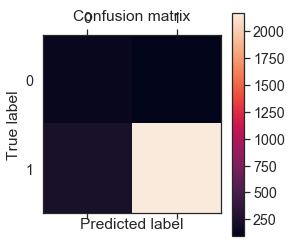

In [33]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

print(cm)

# Show confusion matrix in a separate window
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

**We can see that our model has predicted the sentiment of reviews with a 88% accuracy, but looking at the confusion matrix we can see it's not doing that great of a job classifying.**

For a breakdown of the confusion matrix, we have:

We have considered 0 <- Negative and 1 <- Positive.
For business scenario, we see that classifying a positive reviews as a neagtive one is detrimental.

>140 predicted negative (-1), and was negative (-1). True Negative.

>2196 predicted positive (+1), and was positive (+1). True Positive.

>198 predicted negative (-1), but was positive (+1). False Negative.

>110 predicted positive (+1), but was negative (-1). False Positive.

So our classifier is getting a lot of the positives, but there's a high number of false predictions. We'll see if we can improve these metrics with other classifiers below.

### Cross Validation:

*In cross validation, where we generate a training and testing set 10 different times on the same data in different positions.*


The relevant class from the sklearn library is ShuffleSplit. This performs a shuffle first and then a split of the data into train/test. Since it's an iterator, it will perform a random shuffle and split for each iteration.

The n_splits parameter in ShuffleSplit is the number of times to randomize the data and then split it 80/20, whereas the cv parameter in cross_val_score is the number of folds. 

In [34]:
from sklearn.model_selection import ShuffleSplit

X = df.review
y = df.sentiment

ss = ShuffleSplit(n_splits=10, test_size=0.2)
sm = SMOTE()

accs = []
cms = []

for train_index, test_index in ss.split(X):
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Fit vectorizer and transform X train, then transform X test
    X_train_vect = vect.fit_transform(X_train)
    X_test_vect = vect.transform(X_test)
    
    # Oversample
    X_train_res, y_train_res = sm.fit_sample(X_train_vect, y_train)
    
    # Fit Naive Bayes on the vectorized X with y train labels, 
    # then predict new y labels using X test
    nb.fit(X_train_res, y_train_res)
    y_pred = nb.predict(X_test_vect)
    
    # Determine test set accuracy and f1 score on this fold using the true y labels and predicted y labels
    accs.append(accuracy_score(y_test, y_pred))
    cms.append(confusion_matrix(y_test, y_pred))
    
print("\nAverage accuracy across folds: {:.2f}%".format(sum(accs) / len(accs) * 100))
print("\nAverage Confusion Matrix across folds: \n {}".format(sum(cms) / len(cms)))


Average accuracy across folds: 87.69%

Average Confusion Matrix across folds: 
 [[ 148.7  104.2]
 [ 221.2 2169.9]]


**This plot shows the Accuracy of the Naive Bayes classifier in predicting the sentiments for all the 10 cases of the cross-validation. The final accuracy metric calculation is obtained through the average of the 10 validations.**

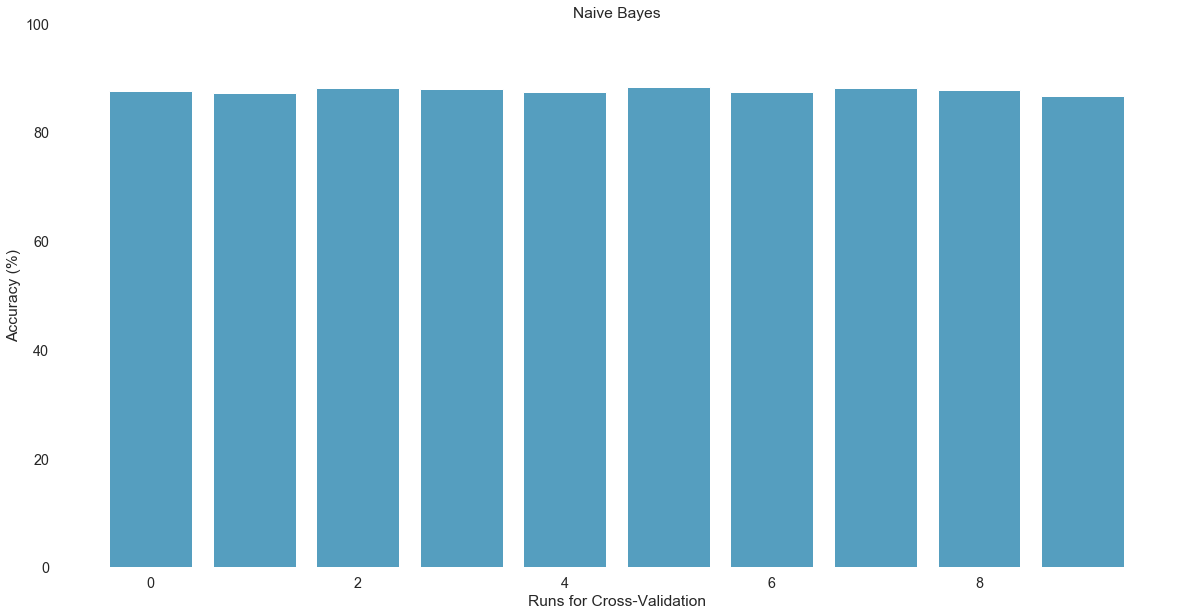

In [35]:
f, ax = plt.subplots(figsize=(20, 10))
acc_scores = [round(a * 100, 1) for a in accs]
x1 = np.arange(len(acc_scores))
ax.bar(x1, acc_scores, color='#559ebf')
    
ax.set_ylabel('Accuracy (%)')
ax.set_xlabel('Runs for Cross-Validation')
ax.set_title('Naive Bayes')
ax.set_ylim([0, 100])

sns.despine(bottom=True, left=True)
plt.show()
    

#### Below are the multiple machine learning classifcation algorithms that are used and the explanation for the same:


> Naive Bayes classifier for multivariate Bernoulli models. Like MultinomialNB, this classifier is suitable for discrete data. The difference is that MultinomialNB works with occurrence counts.

> SGDClassifier: This estimator implements regularized linear models with stochastic gradient descent (SGD) learning: the gradient of the loss is estimated each sample at a time and the model is updated along the way with a decreasing strength schedule (aka learning rate). SGD allows minibatch (online/out-of-core) learning, see the partial_fit method

>Similar to SVC with parameter kernel=’linear’, but implemented in terms of liblinear rather than libsvm, so it has more flexibility in the choice of penalties and loss functions and should scale better to large numbers of samples.

>Random Forest: A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. 

>MLP Classifier: The model is part of the Neural Net Classifier class and this model optimizes the log-loss function using stochastic gradient descent.


In [ ]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

X = df.review
y = df.sentiment

cv = ShuffleSplit(n_splits=20, test_size=0.2)

models = [
    MultinomialNB(),
    BernoulliNB(),
    LogisticRegression(),
    SGDClassifier(),
    LinearSVC(),
    RandomForestClassifier(),
    MLPClassifier()
]

sm = SMOTE()

# Init a dictionary for storing results of each run for each model
results = {
    model.__class__.__name__: {
        'accuracy': [], 
        'confusion_matrix': []
    } for model in models
}

for train_index, test_index in cv.split(X):
    X_train, X_test  = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    X_train_vect = vect.fit_transform(X_train)    
    X_test_vect = vect.transform(X_test)
    
    X_train_res, y_train_res = sm.fit_sample(X_train_vect, y_train)
    
    for model in models:
        model.fit(X_train_res, y_train_res)
        y_pred = model.predict(X_test_vect)
        
        acc = accuracy_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        
        results[model.__class__.__name__]['accuracy'].append(acc)
        results[model.__class__.__name__]['confusion_matrix'].append(cm)

In [ ]:
sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])

In [20]:
for model, d in results.items():
    avg_acc = sum(d['accuracy']) / len(d['accuracy']) * 100
    avg_cm = sum(d['confusion_matrix']) / len(d['confusion_matrix'])
    
    slashes = '-' * 30
    
    s = f"""{model}\n{slashes}
        Avg. Accuracy: {avg_acc:.2f}%
        Avg. Confusion Matrix: 
        \n{avg_cm}
        """
    print(s)

MultinomialNB
------------------------------
        Avg. Accuracy: 87.57%
        Avg. Confusion Matrix: 
        
[[ 143.4   105.35]
 [ 223.2  2172.05]]
        
BernoulliNB
------------------------------
        Avg. Accuracy: 70.70%
        Avg. Confusion Matrix: 
        
[[  72.45  176.3 ]
 [ 598.45 1796.8 ]]
        
LogisticRegression
------------------------------
        Avg. Accuracy: 88.57%
        Avg. Confusion Matrix: 
        
[[ 153.35   95.4 ]
 [ 206.7  2188.55]]
        
SGDClassifier
------------------------------
        Avg. Accuracy: 88.17%
        Avg. Confusion Matrix: 
        
[[ 148.2   100.55]
 [ 212.25 2183.  ]]
        
LinearSVC
------------------------------
        Avg. Accuracy: 88.42%
        Avg. Confusion Matrix: 
        
[[ 144.95  103.8 ]
 [ 202.4  2192.85]]
        
RandomForestClassifier
------------------------------
        Avg. Accuracy: 88.57%
        Avg. Confusion Matrix: 
        
[[  70.15  178.6 ]
 [ 123.6  2271.65]]
        
MLPClass

### We have the highest model accuracy achieved with MLP Classifier, the accuracy is of 91% which is considered very good for Binary prediction. The leats prediction is from Bernoulli NB Classfier, which makes sense because it works well with discrete data and this is classfication model problem.